In [1]:
import cv2 as cv

In [2]:
from PIL import Image
import sys
import os
import urllib
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time
from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





### Download an SSD model for face detection

In [3]:
# https://github.com/yeephycho/tensorflow-face-detection
FROZEN_GRAPH_NAME = 'data/frozen_inference_graph_face.pb'
!wget https://github.com/yeephycho/tensorflow-face-detection/blob/master/model/frozen_inference_graph_face.pb?raw=true -O {FROZEN_GRAPH_NAME}

--2020-02-17 18:58:33--  https://github.com/yeephycho/tensorflow-face-detection/blob/master/model/frozen_inference_graph_face.pb?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yeephycho/tensorflow-face-detection/raw/master/model/frozen_inference_graph_face.pb [following]
--2020-02-17 18:58:33--  https://github.com/yeephycho/tensorflow-face-detection/raw/master/model/frozen_inference_graph_face.pb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yeephycho/tensorflow-face-detection/master/model/frozen_inference_graph_face.pb [following]
--2020-02-17 18:58:33--  https://raw.githubusercontent.com/yeephycho/tensorflow-face-detection/master/model/frozen_inference_graph_face.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)

### Load the frozen graph

In [4]:
output_dir=''
frozen_graph = tf.GraphDef()
with open(os.path.join(output_dir, FROZEN_GRAPH_NAME), 'rb') as f:
    frozen_graph.ParseFromString(f.read())

### A few magical constants

In [5]:
# https://github.com/NVIDIA-AI-IOT/tf_trt_models/blob/master/tf_trt_models/detection.py
INPUT_NAME='image_tensor'
BOXES_NAME='detection_boxes'
CLASSES_NAME='detection_classes'
SCORES_NAME='detection_scores'
MASKS_NAME='detection_masks'
NUM_DETECTIONS_NAME='num_detections'

input_names = [INPUT_NAME]
output_names = [BOXES_NAME, CLASSES_NAME, SCORES_NAME, NUM_DETECTIONS_NAME]

In [49]:
# suppress boxes that are below the threshold.. 
DETECTION_THRESHOLD = 0.5

### Optimize the frozen graph using TensorRT

In [6]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Linked TensorRT version: (6, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (6, 0, 1)
INFO:tensorflow:Running against TensorRT version 6.0.1


### Open USB Camera For Capturing Video

In [57]:
cap = cv.VideoCapture(1)

In [58]:
cap

<VideoCapture 0x7e887957f0>

### Create session and load graph

In [9]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

# use this if you want to try on the optimized TensorRT graph
# Note that this will take a while
# tf.import_graph_def(trt_graph, name='')

# use this if you want to try directly on the frozen TF graph
# this is much faster
tf.import_graph_def(frozen_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

### Run network on Image & Display Results

In [52]:
def detect_faces(tf_sess, image, image_resized):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })

    boxes = boxes[0] # index by 0 to remove batch dimension
    scores = scores[0]
    classes = classes[0]
    num_detections = num_detections[0]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.imshow(image)

    # plot boxes exceeding score threshold
    for i in range(int(num_detections)):
        if scores[i] < DETECTION_THRESHOLD:
            continue
        # scale box to image coordinates
        box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

        # display rectangle
        patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
        ax.add_patch(patch)

        # display class index and score
        plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

    plt.show()

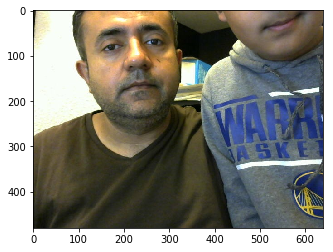

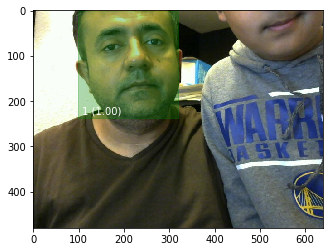

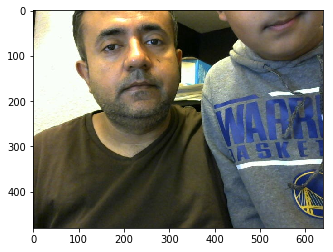

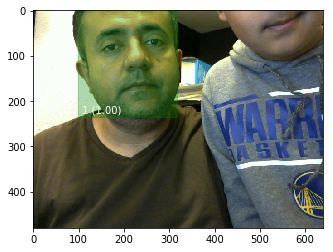

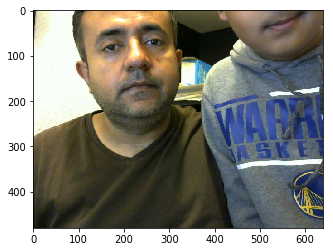

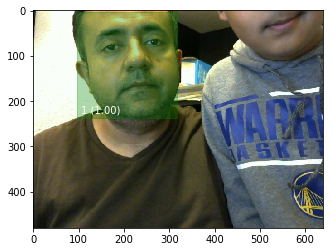

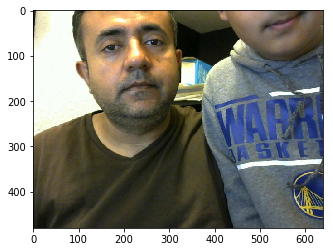

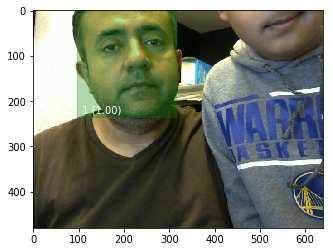

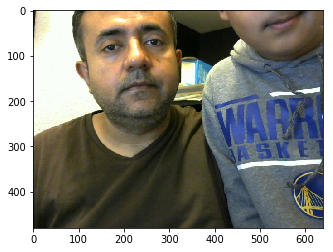

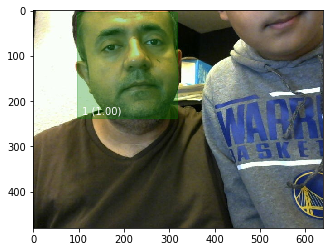

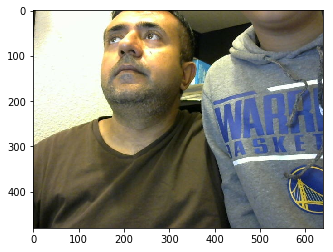

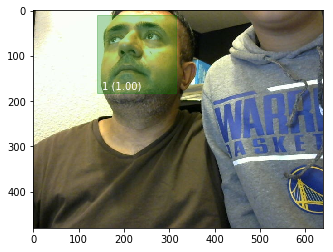

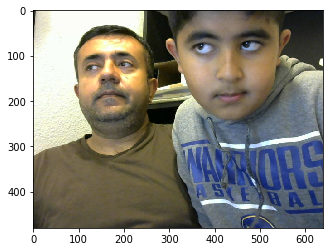

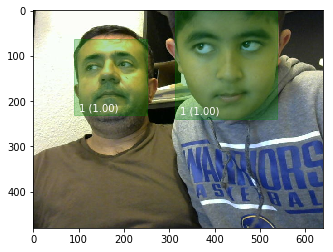

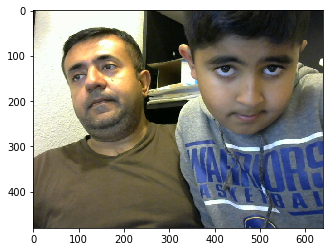

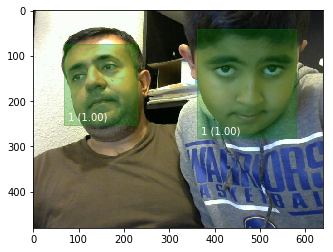

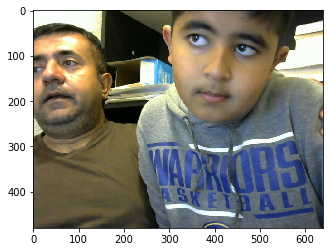

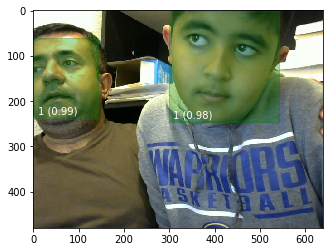

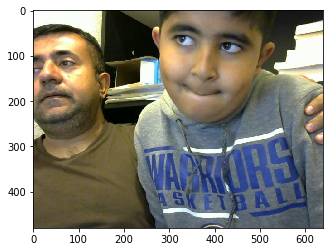

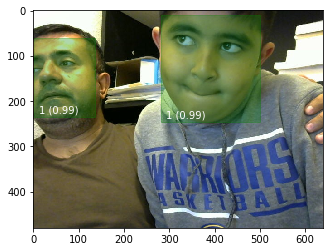

In [59]:
count = 0

# write the image to a local file
while count < 10:
    ret, frame = cap.read()
    if ret:
        cv.imwrite("image%d.jpg" % count, frame)
        image = Image.open('image%d.jpg' % count)

        plt.imshow(image)

        image_resized = np.array(image.resize((300, 300)))
        image = np.array(image)
    
        detect_faces(tf_sess, image, image_resized)
        
    count += 1
    time.sleep(10)

### Benchmark

In [60]:
num_samples = 50

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.088302 seconds


### Close session to release resources

In [56]:
cap.release()

cv.destroyAllWindows()

In [ ]:
tf_sess.close()